In [2]:
import os
import numpy
import soundfile

**Data Loading & Feature Extraction**

Creation of the training dataset and labels.

In [37]:
# Directory containing the audio files
audio_directory = ".\\audio_by_gender\\"

audio_files_chunks = []
features = []
labels = []
# Set the desired chunk length in seconds
chunk_length = 2  # seconds

import soundfile as sf
import torch
import torch.nn.functional as F
from torchsummary import summary
import fairseq  
import os
import numpy as np
import pandas as pd

# Load the PyTorch model checkpoint
cp_path = '.\\wav2vec_small.pt'
model, cfg, task = fairseq.checkpoint_utils.load_model_ensemble_and_task([cp_path])
model = model[0]
model.eval()

kernel_size = 10


"""Since I get an overflow of memory I'm just going to use 99 files for this part."""
count = 0
for root, dirs, files in os.walk(audio_directory):
    for file in files:
        if file.endswith(".flac"):

            if count % 110 == 0:  # to have an homogeneous distribution among classes
                audio_file = os.path.join(root, file)
                speaker_id = int(os.path.splitext(os.path.basename(audio_file))[0].split('-')[0])
                # Load the audio file
                y, sr = sf.read(audio_file, dtype='float32')
                # Calculate the number of samples in each chunk
                chunk_samples = int(chunk_length * sr)
                # Split the audio into 2-second subsequent chunks
                for i in range(0, len(y), chunk_samples):
                    chunk = y[i:i + chunk_samples]
                    if len(chunk) == chunk_samples:

                        z = model.feature_extractor(torch.tensor(chunk).view(1, chunk_samples).float())  # wav2vec function
                        """Since I can't use the original feature aggregator function, I'll calculate the mean over the number of channels
                        Not sure is the right approach"""
                        c = torch.squeeze(torch.mean(z, dim=1)).to(torch.float16)
 
                        features.append(c.detach().numpy())  # If I don't detach I can't call sklearn functions
                        labels.append(speaker_id)
            count +=1
            print("{} files processed".format(count))

data = [features, labels]


1 files processed
2 files processed
3 files processed
4 files processed
5 files processed
6 files processed
7 files processed
8 files processed
9 files processed
10 files processed
11 files processed
12 files processed
13 files processed
14 files processed
15 files processed
16 files processed
17 files processed
18 files processed
19 files processed
20 files processed
21 files processed
22 files processed
23 files processed
24 files processed
25 files processed
26 files processed
27 files processed
28 files processed
29 files processed
30 files processed
31 files processed
32 files processed
33 files processed
34 files processed
35 files processed
36 files processed
37 files processed
38 files processed
39 files processed
40 files processed
41 files processed
42 files processed
43 files processed
44 files processed
45 files processed
46 files processed
47 files processed
48 files processed
49 files processed
50 files processed
51 files processed
52 files processed
53 files processed
54

In [2]:
labels

[1462,
 1462,
 1462,
 1462,
 1462,
 1462,
 1462,
 1585,
 1585,
 1585,
 1585,
 1585,
 1585,
 1630,
 1630,
 1686,
 1686,
 1686,
 1919,
 1993,
 2035,
 2035,
 2035,
 2035,
 2035,
 2412,
 2412,
 2412,
 2412,
 2506,
 3536,
 3536,
 3536,
 3536,
 3663,
 3663,
 3663,
 3663,
 3663,
 3663,
 3663,
 3663,
 3915,
 3915,
 3915,
 4153,
 4153,
 4323,
 4831,
 4831,
 4831,
 4831,
 5543,
 5543,
 5895,
 5895,
 6123,
 6313,
 6345,
 6345,
 6455,
 6455,
 6455,
 700,
 8173,
 8173,
 84,
 84,
 84,
 84,
 116,
 1255,
 1272,
 1272,
 1650,
 1650,
 1701,
 2078,
 2078,
 2078,
 2078,
 2078,
 2078,
 2428,
 251,
 251,
 251,
 2902,
 3660,
 3660,
 3752,
 3752,
 422,
 422,
 422,
 422,
 422,
 422,
 422,
 422,
 422,
 4515,
 4572,
 4572,
 4572,
 4572,
 4572,
 5694,
 5694,
 5694,
 6241,
 6241,
 6241,
 6241,
 6241,
 6267,
 6467,
 6467,
 6467,
 652,
 652,
 652,
 652,
 6841,
 7601,
 7601,
 7697,
 777,
 777,
 777,
 777,
 777,
 777,
 7976,
 7976,
 8297,
 8297]

Visualization of wav2vec model for better understanding of it's functioning

In [28]:
for name, layer in model.named_children():
    print(name, layer)



feature_extractor ConvFeatureExtractionModel(
  (conv_layers): ModuleList(
    (0): Sequential(
      (0): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
      (1): Dropout(p=0.0, inplace=False)
      (2): Fp32GroupNorm(512, 512, eps=1e-05, affine=True)
      (3): GELU(approximate='none')
    )
    (1): Sequential(
      (0): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
      (1): Dropout(p=0.0, inplace=False)
      (2): GELU(approximate='none')
    )
    (2): Sequential(
      (0): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
      (1): Dropout(p=0.0, inplace=False)
      (2): GELU(approximate='none')
    )
    (3): Sequential(
      (0): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
      (1): Dropout(p=0.0, inplace=False)
      (2): GELU(approximate='none')
    )
    (4): Sequential(
      (0): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
      (1): Dropout(p=0.0, inplace=False)
      (2): GELU(approximate='none'

**Training and Quantitative Analysis**

Creation of training and testing datasets

In [131]:
from sklearn.model_selection import train_test_split

X_train_, X_test_, y_train, y_test = train_test_split(features, labels, test_size = 0.3, shuffle=True, random_state=1)

*Logistic Regression*

In [48]:
from sklearn.linear_model import LogisticRegression

# Initialize the model
model = LogisticRegression()

# Train the model
model.fit(X_train_, y_train)

y_pred_lr = model.predict(X_test_)  # X_test contains feature vectors of the testing dataset

from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

precision_lr = np.mean(precision_score(y_test, y_pred_lr, average=None))
recall_lr = np.mean(recall_score(y_test, y_pred_lr, average=None))
accuracy_lr = accuracy_score(y_test, y_pred_lr)
f1_lr = np.mean(f1_score(y_test, y_pred_lr, average=None))

# Print the objective metrics
print("Precision_LR:", precision_lr)
print("Recall_LR:", recall_lr)
print("Accuracy_LR:", accuracy_lr)
print("F1-score_LR:", f1_lr)


Precision_LR: 0.002857142857142857
Recall_LR: 0.04
Accuracy_LR: 0.07142857142857142
F1-score_LR: 0.005333333333333333


c:\Users\rales\miniconda3\envs\VOISEED3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


*Support Vector Machines*

In [49]:
from sklearn.svm import SVC

# Initialize the SVM classifier
svm_model = SVC(kernel='linear')

svm_model.fit(X_train_, y_train)

y_pred_svm = svm_model.predict(X_test_)

precision_svm = np.mean(precision_score(y_test, y_pred_svm, average=None))
recall_svm = np.mean(recall_score(y_test, y_pred_svm, average=None))
accuracy_svm = accuracy_score(y_test, y_pred_svm)
f1_svm = np.mean(f1_score(y_test, y_pred_svm, average=None))

# Print the objective metrics
print("Precision_SVM:", precision_svm)
print("Recall_SVM:", recall_svm)
print("Accuracy_SVM:", accuracy_svm)
print("F1-score_SVM:", f1_svm)

Precision_SVM: 0.002857142857142857
Recall_SVM: 0.04
Accuracy_SVM: 0.07142857142857142
F1-score_SVM: 0.005333333333333333


c:\Users\rales\miniconda3\envs\VOISEED3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


*FeedForward Neural Network*

In [120]:
X_train_

[array([-0.000607 , -0.000535 , -0.000686 , -0.000745 , -0.000574 ,
        -0.0006676, -0.001045 , -0.0009594, -0.001076 , -0.000794 ,
        -0.0006166, -0.000759 , -0.001051 , -0.0005984, -0.00066  ,
        -0.0009604, -0.000926 , -0.0007324, -0.0009365, -0.001121 ,
        -0.0007606, -0.001003 , -0.001193 , -0.0009704, -0.0007887,
        -0.001186 , -0.001758 , -0.001683 , -0.001561 , -0.001294 ,
        -0.001374 , -0.002361 , -0.00173  , -0.001858 , -0.001745 ,
        -0.001854 , -0.001151 , -0.0008564, -0.000696 , -0.0008035,
        -0.002039 , -0.002228 , -0.001662 , -0.001381 , -0.001249 ,
        -0.001536 , -0.001925 , -0.002014 , -0.001959 , -0.001897 ,
        -0.001492 , -0.001392 , -0.001725 , -0.002672 , -0.001516 ,
        -0.001363 , -0.002722 , -0.002321 , -0.002224 , -0.002033 ,
        -0.001061 , -0.001173 , -0.001034 , -0.0008116, -0.00088  ,
        -0.001913 , -0.001936 , -0.001507 , -0.00102  , -0.001225 ,
        -0.001349 , -0.001261 , -0.001228 , -0.0

Change of fatures dimensions for training purposes.

In [134]:
X_train = []
for i in range(len(X_train_)):
    X_train.append(np.ravel(X_train_[i]))

X_test = []
for i in range(len(X_test_)):
    X_test.append(np.ravel(X_test_[i]))

X_train = torch.Tensor(np.asarray(X_train))
y_train = torch.Tensor(np.asarray(y_train)).long()
X_test = torch.Tensor(np.asarray(X_test))
y_test = torch.Tensor(np.asarray(y_test)).long()

In [124]:
X_train

tensor([[-0.0006, -0.0005, -0.0007,  ..., -0.0008, -0.0006, -0.0008],
        [-0.0006, -0.0008, -0.0012,  ..., -0.0010, -0.0009, -0.0011],
        [-0.0008, -0.0010, -0.0012,  ..., -0.0009, -0.0011, -0.0010],
        ...,
        [-0.0012, -0.0010, -0.0008,  ..., -0.0006, -0.0005, -0.0016],
        [-0.0010, -0.0009, -0.0009,  ..., -0.0009, -0.0011, -0.0008],
        [-0.0014, -0.0008, -0.0010,  ..., -0.0011, -0.0007, -0.0008]])

Change of the labels vector into a matrix that contains one-hot vectors, with the one representing the position of the true ID. This is necessary if I want to use the SoftMax function to classify the right ID. Since in the softmax function what will be the predicted ID is the one with the highest value, I can check if the predicted output and the corresponding one-hot vector have their maximum at the same index.

In [202]:
ids_to_class_mapping = {id: index for index, id in enumerate(np.unique(labels))}  # Creation of a Dictionary that maps IDs to indexes

# Map IDs to class indices
y_train_mapped = torch.tensor([ids_to_class_mapping[id.item()] for id in y_train])
y_test_mapped = torch.tensor([ids_to_class_mapping[id.item()] for id in y_test])


# Calculate the number of unique classes
num_classes = len(ids_to_class_mapping)

# Create a zero-filled one-hot encoding tensor
one_hot_labels = torch.zeros(y_train.size(0), num_classes)
one_hot_labels_test = torch.zeros(y_test_mapped.size(0), num_classes)

# Use scatter_ to fill the one-hot tensor
one_hot_labels.scatter_(1, y_train_mapped.unsqueeze(1), 1)
one_hot_labels_test.scatter_(1, y_test_mapped.unsqueeze(1), 1)


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [217]:
y_train_mapped, y_test_mapped

(tensor([28,  6, 37, 37, 31, 36, 45, 41, 28,  3,  4, 32, 12, 37, 40,  3, 18, 18,
         10, 25, 23,  3, 25, 42, 48, 19, 17,  0, 34, 31, 12,  3, 34,  6,  2, 47,
         13, 25, 33, 19, 14, 27, 17, 42, 26, 31, 32, 17,  1,  9,  6, 23, 48, 29,
         37, 24, 10, 18, 41,  9,  9, 39, 17, 41,  5, 10, 10, 38, 11,  2,  3,  3,
         37, 31, 42, 22,  0, 32, 11, 21, 19, 31, 44, 10,  2, 15, 30, 17, 19,  7,
          6, 18, 46,  8, 25]),
 tensor([18,  9, 25, 25, 25, 40, 27, 18,  4,  4, 16,  3,  4, 13, 23, 26, 32, 33,
         47, 20,  6, 13,  8,  3, 35, 23,  9,  6,  3,  0, 34, 43, 27, 35, 44, 25,
          0, 10,  9, 46, 24,  9]))

In [186]:
one_hot_labels

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [191]:
one_hot_labels[0]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [220]:
one_hot_labels_test[0]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [227]:
import torch.nn as nn
import torch.optim as optim


input_dim = len(X_train[0])


# Definition of the FNN model in PyTorch
class FNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        #super(FNN, self).__init__()
        super().__init__()

        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, num_classes)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.softmax(self.fc3(x), dim=1)
        return x

# Creation of the FNN model
fnn_model = FNN(input_dim, int(num_classes))

# Definition of the optimizer and loss function
optimizer = optim.Adam(fnn_model.parameters())
criterion = nn.CrossEntropyLoss()

epochs = 10
fnn_model.train()

# Training loop for the FNN model
for epoch in range(epochs):
    optimizer.zero_grad()
    output = fnn_model(X_train)
    loss = criterion(output, one_hot_labels)
    loss.backward()
    optimizer.step()

fnn_model.eval()
# Evaluation for the FNN model
with torch.no_grad():
    outputs = fnn_model(X_test)

    _, y_pred_fnn = torch.max(outputs, 1)
    fnn_accuracy = (outputs == one_hot_labels_test).sum().item() / len(one_hot_labels_test)

for i in range(len(outputs)):

    print("OUTPUT = {}\n LABEL = {}".format(torch.argmax(outputs[i]), torch.argmax(one_hot_labels_test[i])))



print("FNN Accuracy (PyTorch):", fnn_accuracy)

<class '__main__.FNN'>
OUTPUT = 6
 LABEL = 18
OUTPUT = 6
 LABEL = 9
OUTPUT = 6
 LABEL = 25
OUTPUT = 6
 LABEL = 25
OUTPUT = 6
 LABEL = 25
OUTPUT = 6
 LABEL = 40
OUTPUT = 6
 LABEL = 27
OUTPUT = 6
 LABEL = 18
OUTPUT = 6
 LABEL = 4
OUTPUT = 6
 LABEL = 4
OUTPUT = 6
 LABEL = 16
OUTPUT = 6
 LABEL = 3
OUTPUT = 6
 LABEL = 4
OUTPUT = 6
 LABEL = 13
OUTPUT = 6
 LABEL = 23
OUTPUT = 6
 LABEL = 26
OUTPUT = 6
 LABEL = 32
OUTPUT = 6
 LABEL = 33
OUTPUT = 6
 LABEL = 47
OUTPUT = 6
 LABEL = 20
OUTPUT = 6
 LABEL = 6
OUTPUT = 6
 LABEL = 13
OUTPUT = 6
 LABEL = 8
OUTPUT = 6
 LABEL = 3
OUTPUT = 6
 LABEL = 35
OUTPUT = 6
 LABEL = 23
OUTPUT = 6
 LABEL = 9
OUTPUT = 6
 LABEL = 6
OUTPUT = 6
 LABEL = 3
OUTPUT = 6
 LABEL = 0
OUTPUT = 6
 LABEL = 34
OUTPUT = 6
 LABEL = 43
OUTPUT = 6
 LABEL = 27
OUTPUT = 6
 LABEL = 35
OUTPUT = 6
 LABEL = 44
OUTPUT = 6
 LABEL = 25
OUTPUT = 6
 LABEL = 0
OUTPUT = 6
 LABEL = 10
OUTPUT = 6
 LABEL = 9
OUTPUT = 6
 LABEL = 46
OUTPUT = 6
 LABEL = 24
OUTPUT = 6
 LABEL = 9
FNN Accuracy (PyTorch): 0.

*Convolutional Neural Network*

In [254]:
X_train_exp = X_train.unsqueeze(1)
X_test_exp = X_test.unsqueeze(1)

X_train_exp_ = X_train.view(1, 95, 99)
X_test_exp_ = X_test.view(1, 42, 99)


# Define the CNN model in PyTorch
class CNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=3)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=2)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(6016, 128)
        self.fc2 = nn.Linear(128, num_classes)


    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = self.flatten(x)
        #x = x.view(x.size(0), -1)  # Flatten the tensor
        x = torch.relu(self.fc1(x))  
        x = torch.softmax(self.fc2(x), dim=1)
        return x

# Creation of the CNN model
cnn_model = CNN(input_dim, num_classes)

# Definition of the optimizer and loss function
optimizer = optim.Adam(cnn_model.parameters())
criterion = nn.CrossEntropyLoss()

# Training loop for the CNN model
epochs = 10
for epoch in range(epochs):
    optimizer.zero_grad()
    output = cnn_model(X_train_exp)
    loss = criterion(output, one_hot_labels)
    loss.backward()
    optimizer.step()

# Evaluation for the CNN model
with torch.no_grad():
    outputs = fnn_model(X_test_exp)
    _, y_pred_cnn = torch.max(outputs, 1)
    cnn_accuracy = (outputs == one_hot_labels_test).sum().item() / len(one_hot_labels_test)


# Print the objective metrics
for i in range(len(outputs)):

    print("OUTPUT = {}\n LABEL = {}".format(torch.argmax(outputs[i]), torch.argmax(one_hot_labels_test[i])))



print("CNN Accuracy (PyTorch):", cnn_accuracy)


OUTPUT = 0
 LABEL = 18
OUTPUT = 0
 LABEL = 9
OUTPUT = 0
 LABEL = 25
OUTPUT = 0
 LABEL = 25
OUTPUT = 0
 LABEL = 25
OUTPUT = 0
 LABEL = 40
OUTPUT = 0
 LABEL = 27
OUTPUT = 0
 LABEL = 18
OUTPUT = 0
 LABEL = 4
OUTPUT = 0
 LABEL = 4
OUTPUT = 0
 LABEL = 16
OUTPUT = 0
 LABEL = 3
OUTPUT = 0
 LABEL = 4
OUTPUT = 0
 LABEL = 13
OUTPUT = 0
 LABEL = 23
OUTPUT = 0
 LABEL = 26
OUTPUT = 0
 LABEL = 32
OUTPUT = 0
 LABEL = 33
OUTPUT = 0
 LABEL = 47
OUTPUT = 0
 LABEL = 20
OUTPUT = 0
 LABEL = 6
OUTPUT = 0
 LABEL = 13
OUTPUT = 0
 LABEL = 8
OUTPUT = 0
 LABEL = 3
OUTPUT = 0
 LABEL = 35
OUTPUT = 0
 LABEL = 23
OUTPUT = 0
 LABEL = 9
OUTPUT = 0
 LABEL = 6
OUTPUT = 0
 LABEL = 3
OUTPUT = 0
 LABEL = 0
OUTPUT = 0
 LABEL = 34
OUTPUT = 0
 LABEL = 43
OUTPUT = 0
 LABEL = 27
OUTPUT = 0
 LABEL = 35
OUTPUT = 0
 LABEL = 44
OUTPUT = 0
 LABEL = 25
OUTPUT = 0
 LABEL = 0
OUTPUT = 0
 LABEL = 10
OUTPUT = 0
 LABEL = 9
OUTPUT = 0
 LABEL = 46
OUTPUT = 0
 LABEL = 24
OUTPUT = 0
 LABEL = 9
CNN Accuracy (PyTorch): 42.0


**Qualitative Analysis**

Probably in the beginning the feature aggregation that I've performed (mean) wasn't the appropriate one. Having the features only 1D, the following procedures don't make much sense, since instead of decrease the dimensionality, they increase it. However I'll proceed as if I had multi-D data to show how I'd work.

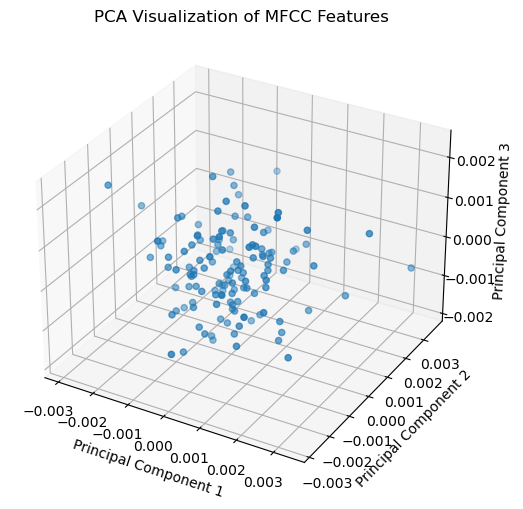

In [259]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

n_components = 3  # The number of components to reduce to

pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(features)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2])
ax.set_title("PCA Visualization of MFCC Features")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")
plt.show()

T-SNE is not a proper approach to do dimensionality reduction for _training_ purposes, it should be used only to do dimensionality reduction for _visualization_ purposes. Usually is used after PCA to have a better representation. For example you decrease data dimensionality with pca from N to a smaller amount like 10 dim, and use tsne to reduce to 3 or 2 dim.

c:\Users\rales\miniconda3\envs\VOISEED3\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
c:\Users\rales\miniconda3\envs\VOISEED3\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


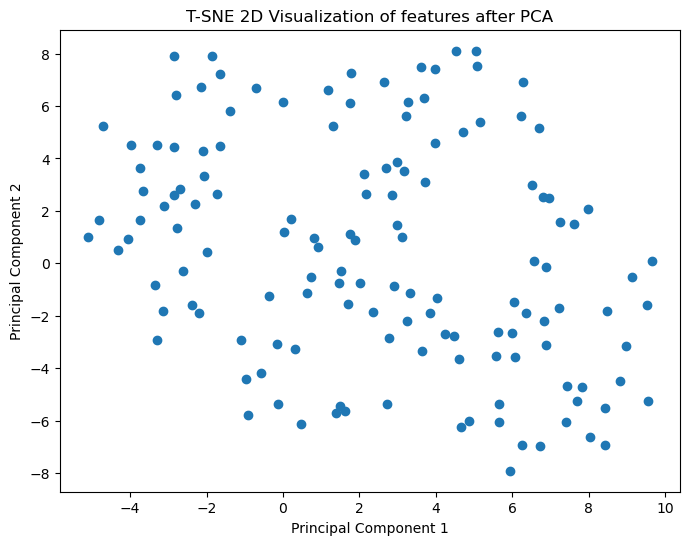

c:\Users\rales\miniconda3\envs\VOISEED3\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
c:\Users\rales\miniconda3\envs\VOISEED3\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


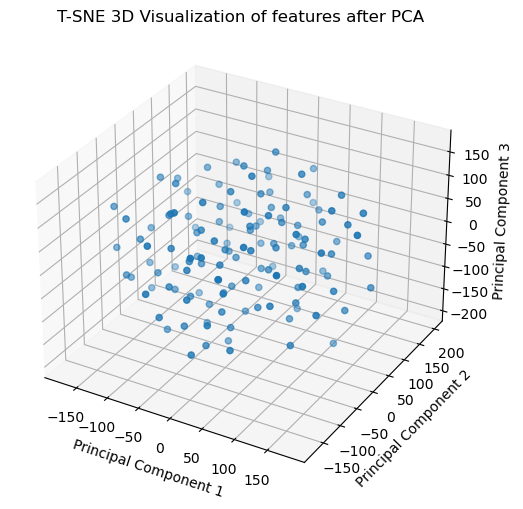

In [264]:
from sklearn.manifold import TSNE

n_components = 2  # The number of components to reduce to

tsne = TSNE(n_components=n_components, random_state=42)
tsne_result = tsne.fit_transform(pca_result)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.scatter(tsne_result[:, 0], tsne_result[:, 1])
ax.set_title("T-SNE 2D Visualization of features after PCA")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
plt.show()

n_components = 3  # The number of components to reduce to

tsne = TSNE(n_components=n_components, random_state=42)
tsne_result = tsne.fit_transform(pca_result)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(tsne_result[:, 0], tsne_result[:, 1], tsne_result[:, 2])
ax.set_title("T-SNE 3D Visualization of features after PCA")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")
plt.show()


c:\Users\rales\miniconda3\envs\VOISEED3\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
c:\Users\rales\miniconda3\envs\VOISEED3\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


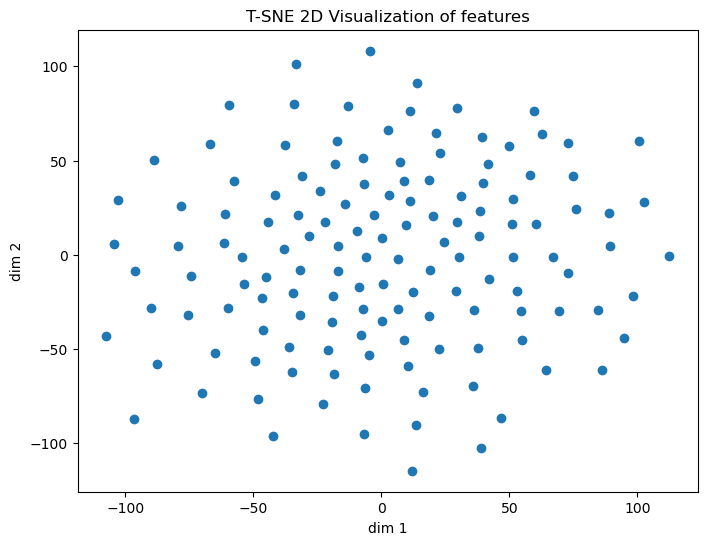

In [265]:
# Assuming your data is stored in 'X' with shape (n_samples, n_features)
n_components = 2  # The number of components to reduce to

tsne = TSNE(n_components=n_components, random_state=42)
tsne_result = tsne.fit_transform(features)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.scatter(tsne_result[:, 0], tsne_result[:, 1])
ax.set_title("T-SNE 2D Visualization of features")
ax.set_xlabel("dim 1")
ax.set_ylabel("dim 2")
plt.show()

c:\Users\rales\miniconda3\envs\VOISEED3\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
c:\Users\rales\miniconda3\envs\VOISEED3\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


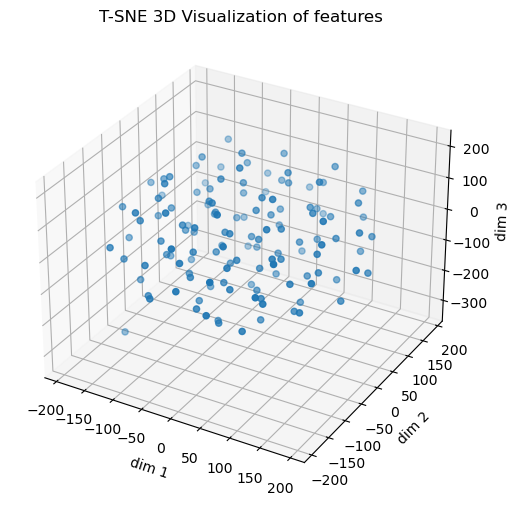

In [266]:
# Assuming your data is stored in 'X' with shape (n_samples, n_features)
n_components = 3  # The number of components to reduce to

tsne = TSNE(n_components=n_components, random_state=42)
tsne_result = tsne.fit_transform(features)
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(tsne_result[:, 0], tsne_result[:, 1], tsne_result[:, 2])
ax.set_title("T-SNE 3D Visualization of features")
ax.set_xlabel("dim 1")
ax.set_ylabel("dim 2")
ax.set_zlabel("dim 3")
plt.show()

For the clustering of the Data K-means is a proper approach. I used as number of clusters the same number of classes that we wanto to obtain.

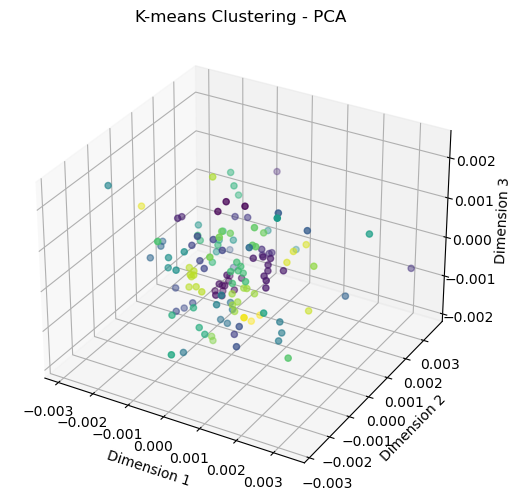

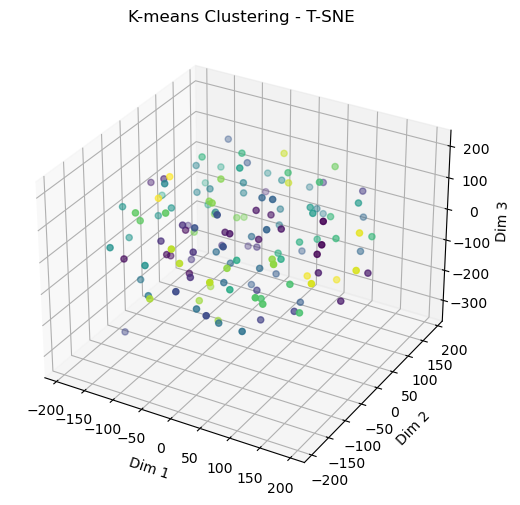

In [273]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Choose the number of clusters (K) based on your problem
n_clusters = num_classes  # Adjust as needed

# Initialization and fit the K-means model
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels_pca = kmeans.fit_predict(pca_result) 
cluster_labels_tsne = kmeans.fit_predict(tsne_result)

# Visualization the clustering results 
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], c=cluster_labels_pca)
ax.set_title('K-means Clustering - PCA')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
plt.show()

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(tsne_result[:, 0], tsne_result[:, 1], tsne_result[:, 2], c=cluster_labels_tsne)
ax.set_title("K-means Clustering - T-SNE")
ax.set_xlabel("Dim 1")
ax.set_ylabel("Dim 2")
ax.set_zlabel("Dim 3")
plt.show()

_Discussion_

I couldn't understand why I was having so much limitations with the memory of my PC for this task. The dataset I was using should be less then 1G, and also when we extract features there is usally a dimensionality reduction. The fact that with 16GB RAM I couldn't process more 100 examples out of 6k makes me think that I was doing something wrong in the loading and extracting procedure, but I coulnd't find the bug.
Due to the data limitation, the training and testing dataset were resultedd to be very small. On top of that, for the same reason they didn't even contain the same classes. So it was impossible for every ML model to be able to learn. Since if I train a model with a dataset that have classes that go from 1-to-5, and then test it with a dataset that have classes that go 6-to-8, it didn't learn the feature-space representation that is associated with those classes.
That explains why LR, SVM and the FNN got results around 0%. For what concernes CNN, probably there are also some errors in the outputs, since each features sample leads the same prediction.
For what concernes the qualitative analysis, it couldn't be performed. For my perspective, the wav2vec repository needs to be updated by the owners. I went down till python 3.7 to be able to use the fairseq library as described in their repo, and still when I called the "feature_aggregator" function as in their example, I got an error saying that it didn't existed.